In [8]:
import numpy as np
import math 
import pandas as pd
from pandas.io.json import json_normalize
import json
import sys  
sys.path.insert(0, './scripts')
from PricingModels import *

def calc_x_reserves(APY,y_reserves,days_until_maturity,time_stretch):
  t=days_until_maturity/(365*time_stretch)
  T=days_until_maturity/365
  return y_reserves/((1-T*(APY/100))**(-1/t)-1)



trades = []
run_matrix=[]
cols = ["init.apy","init.percent_fee","init.days_until_maturity","init.max_order_size","init.time_stretch",\
        "init.market_price","init.target_liquidity","init.target_daily_volume","input.day","input.time",\
        "input.base_market_price", "input.unit_fyt_price","input.base_reserves","input.fyt_reserves",\
        "input.token_in","input.amount_specified","input.token_out","input.direction",\
        "output.trade_volume","output.fee","output.slippage"]

ybas = [
    {
        "vault" : "yWBTC",
        "apy" : 1.7,
        "market_price" : 50000,
        "time_stretch": 40,
        "days_until_maturity": 180,
    },
    {
        "vault" : "yWBTC",
        "apy" : 1.7,
        "market_price" : 50000,
        "time_stretch": 30,
        "days_until_maturity": 180,
    },
    {
        "vault" : "yWBTC",
        "apy" : 1.7,
        "market_price" : 50000,
        "time_stretch": 20,
        "days_until_maturity": 180,
    },
    {
        "vault" : "yWBTC",
        "apy" : 3,
        "market_price" : 50000,
        "time_stretch": 40,
        "days_until_maturity": 180,
    },
    {
        "vault" : "yWBTC",
        "apy" : 3,
        "market_price" : 50000,
        "time_stretch": 30,
        "days_until_maturity": 180,
    },
    {
        "vault" : "yWBTC",
        "apy" : 3,
        "market_price" : 50000,
        "time_stretch": 20,
        "days_until_maturity": 180,
    },
    {
        "vault" : "ycrvSTETH",
        "apy" : 20,
        "market_price" : 1500,
        "time_stretch": 5,
        "days_until_maturity": 90,
    },
]


for target_daily_volume in [5000000,10000000]:
    for target_liquidity in [5000000]:
        for g in [.1]:
                for yba in ybas:
                    np.random.seed(2)
                    APY=yba["apy"]
                    days_until_maturity = yba["days_until_maturity"]
                    market_price = yba["market_price"]
                    time_stretch = yba["time_stretch"]
                    run_matrix.append((yba,g,target_liquidity,target_daily_volume))

                    y_start = target_liquidity/market_price
                    max_order_price=12500
                    max_order_size=max_order_price/market_price 
                    sigma=max_order_size/10


                    x_start = calc_x_reserves(APY,y_start,days_until_maturity,time_stretch)
                    total_supply=x_start
                    t=days_until_maturity/(365*time_stretch)

                    step_size=t/days_until_maturity
                    epsilon=step_size/2
                    m = Market(x_start,y_start,g,t,total_supply,Element_Pricing_Model)
                    print("Days Until Maturity: " + str(days_until_maturity))
                    print("Time Stretch: " + str(time_stretch))
                    print("Fee %: " + str(g*100))
                    print("Starting APY: {:.2f}%".format(m.apy(days_until_maturity)))
                    print("Starting FYT Price: " + str(m.fyt_price()))
                    print("Starting Liquidity: ${:,.2f}".format(x_start*market_price+y_start*market_price*m.fyt_price()))
                    print("Starting Base Reserves: " + str(m.x))
                    print("Starting FYT Reserves: " + str(m.y))
                    x_orders=0
                    x_volume=0
                    y_orders=0
                    y_volume=0

                    total_fees = 0
                    todays_volume = 0
                    todays_fees = 0
                    todays_num_trades = 0
                    day=0
                    while m.t > epsilon:
                        day += 1
                        todays_volume = 0
                        todays_fees = 0
                        todays_num_trades = 0
                        maturity_ratio = day/days_until_maturity
                        ub=target_daily_volume*math.log10(1/maturity_ratio) # log(1/maturity ratio) is used to simulate waning demand over the lifetime of the fyt
                        todays_target_volume = np.random.uniform(ub/2,ub)
                        while todays_target_volume > todays_volume:
                            fee = -1
                            trade = []
                            while fee < 0:
                                # determine order size
                                amount = np.random.normal(max_order_size/2,sigma)
                                lb_amount = max(0.00001,amount)
                                amount = min(max_order_size,lb_amount)
                                # buy fyt or base
                                if np.random.uniform(0,1) < 0.5:
                                    token_in = "base"
                                    token_out = "fyt"
                                else:
                                    token_in = "fyt"
                                    token_out = "base"

                                if np.random.uniform(0,1) < 0.5:
                                    direction="in"
                                else:
                                    direction="out"
                                    

                                start_x_volume = m.x_volume
                                start_y_volume = m.y_volume
                                (without_fee_or_slippage,with_fee,without_fee,fee) = m.swap(amount,direction,token_in,token_out)
                                
                                trade = [APY,g,days_until_maturity,max_order_size,time_stretch,market_price,target_liquidity,target_daily_volume,day,m.t,market_price,m.fyt_price(),m.x,m.y,token_in,amount,token_out,direction,with_fee*market_price,fee*market_price,(without_fee_or_slippage-without_fee)*market_price]
                                
                            trades.append(trade);
                            todays_volume += (m.x_volume - start_x_volume)*market_price + (m.y_volume - start_y_volume)*market_price
                            todays_fees += fee*market_price
                            todays_num_trades += 1
                        print("\tDay: " + str(day) + " FYT Price: " + str(m.fyt_price()) + " Implied APY: " + str(m.apy(days_until_maturity-day+1)) + " Target Volume Factor: {:,.4f}".format(math.log10(1/maturity_ratio)) + " Volume: ${:,.2f}".format(todays_volume) + " Num Trades: " + str(todays_num_trades) + " Fees: ${:,.2f}".format(todays_fees))
                        total_fees += todays_fees
                        m.tick(step_size)

                    print("Ending Liquidity: ${:,.2f}".format(m.x*market_price+m.y*market_price*m.fyt_price()))
                    print("Total volume: ${:,.2f}".format(m.x_volume*market_price+m.y_volume*market_price))
                    print("Total fees: ${:,.2f}".format(total_fees))
                    print("Ending Base Reserves: " + str(m.x))
                    print("Delta Base Reserves: " + str(abs(x_start-m.x)))
                    print("Ending FYT Reserves: " + str(m.y))
                    print("Delta FYT Reserves: " + str(abs(y_start-m.y)))
                    print("Num base orders: " + str(m.x_orders))
                    print("Cum base volume: " + str(m.x_volume))
                    print("Num FYT orders: " + str(m.y_orders))
                    print("Cum FYT volume: " + str(m.y_volume))
                    print("Cum slippage Base: " + str(m.cum_x_slippage))
                    print("Cum slippage FYT: " + str(m.cum_y_slippage))
                    print("Cum fees Base: " + str(m.cum_x_fees))
                    print("Cum fees FYT: " + str(m.cum_y_fees))
                    print("Ending FYT Price: " + str(m.fyt_price()))
                    print("Ending Time: " + str(m.t))
                    print("##################################################################")



#df = pd.DataFrame.from_dict(json_normalize(trades), orient='columns')
df = pd.DataFrame(trades,columns=cols)




Days Until Maturity: 180
Time Stretch: 40
Fee %: 10.0
Starting APY: 1.70%
Starting FYT Price: 0.9916164383561644
Starting Liquidity: $10,062,498.87
Starting Base Reserves: 102.0883335589536
Starting FYT Reserves: 100.0
	Day: 1 FYT Price: 0.9907018427776642 Implied APY: 1.8854596589736576 Target Volume Factor: 2.2553 Volume: $8,101,701.79 Num Trades: 1306 Fees: $7,165.92
	Day: 2 FYT Price: 0.9916221948010377 Implied APY: 1.7083234064923027 Target Volume Factor: 1.9542 Volume: $5,721,403.33 Num Trades: 921 Fees: $5,014.75
	Day: 3 FYT Price: 0.99206151080111 Implied APY: 1.627836268311704 Target Volume Factor: 1.7782 Volume: $5,419,788.32 Num Trades: 871 Fees: $4,389.45
	Day: 4 FYT Price: 0.9915394253403801 Implied APY: 1.7446947744413945 Target Volume Factor: 1.6532 Volume: $7,823,702.85 Num Trades: 1248 Fees: $6,647.30
	Day: 5 FYT Price: 0.9916916530209818 Implied APY: 1.7230378678077445 Target Volume Factor: 1.5563 Volume: $6,109,257.22 Num Trades: 976 Fees: $5,095.93
	Day: 6 FYT Price

	Day: 74 FYT Price: 0.9978955134238151 Implied APY: 0.7178856077640059 Target Volume Factor: 0.3860 Volume: $1,271,657.58 Num Trades: 199 Fees: $272.69
	Day: 75 FYT Price: 0.997990006651356 Implied APY: 0.6921203511840347 Target Volume Factor: 0.3802 Volume: $1,850,764.14 Num Trades: 299 Fees: $389.49
	Day: 76 FYT Price: 0.9980226307691827 Implied APY: 0.687371208807905 Target Volume Factor: 0.3745 Volume: $1,409,495.10 Num Trades: 227 Fees: $295.98
	Day: 77 FYT Price: 0.9979894455944938 Implied APY: 0.7056272673170929 Target Volume Factor: 0.3688 Volume: $1,796,628.91 Num Trades: 289 Fees: $368.11
	Day: 78 FYT Price: 0.9979611292280235 Implied APY: 0.7225124580305103 Target Volume Factor: 0.3632 Volume: $1,574,554.26 Num Trades: 252 Fees: $305.39
	Day: 79 FYT Price: 0.9977319385012918 Implied APY: 0.8116102421847876 Target Volume Factor: 0.3576 Volume: $917,293.04 Num Trades: 143 Fees: $195.30
	Day: 80 FYT Price: 0.9975959478928845 Implied APY: 0.868791108016978 Target Volume Factor: 

	Day: 166 FYT Price: 0.9996382087346366 Implied APY: 0.8803587457176021 Target Volume Factor: 0.0352 Volume: $92,484.35 Num Trades: 16 Fees: $3.38
	Day: 167 FYT Price: 0.9996734475041018 Implied APY: 0.8513690071631417 Target Volume Factor: 0.0326 Volume: $162,480.72 Num Trades: 25 Fees: $5.32
	Day: 168 FYT Price: 0.9996919220484837 Implied APY: 0.8649880946419976 Target Volume Factor: 0.0300 Volume: $87,815.56 Num Trades: 14 Fees: $2.68
	Day: 169 FYT Price: 0.9997157400585587 Implied APY: 0.86462398855069 Target Volume Factor: 0.0274 Volume: $89,139.64 Num Trades: 14 Fees: $2.56
	Day: 170 FYT Price: 0.9997370644609062 Implied APY: 0.8724679251750306 Target Volume Factor: 0.0248 Volume: $86,626.47 Num Trades: 14 Fees: $2.27
	Day: 171 FYT Price: 0.999762781771781 Implied APY: 0.865846532999287 Target Volume Factor: 0.0223 Volume: $66,177.14 Num Trades: 11 Fees: $1.57
	Day: 172 FYT Price: 0.9997896408465884 Implied APY: 0.8531232332804185 Target Volume Factor: 0.0197 Volume: $81,922.52 N

	Day: 46 FYT Price: 0.9942996704899395 Implied APY: 1.5412002008682086 Target Volume Factor: 0.5925 Volume: $1,703,718.27 Num Trades: 271 Fees: $957.02
	Day: 47 FYT Price: 0.9942819830994946 Implied APY: 1.5575195288690193 Target Volume Factor: 0.5832 Volume: $2,753,531.27 Num Trades: 434 Fees: $1,563.63
	Day: 48 FYT Price: 0.9944230803876077 Implied APY: 1.5305080139271996 Target Volume Factor: 0.5740 Volume: $2,522,560.39 Num Trades: 397 Fees: $1,416.73
	Day: 49 FYT Price: 0.994611510156911 Implied APY: 1.4899990853996208 Target Volume Factor: 0.5651 Volume: $2,254,185.54 Num Trades: 361 Fees: $1,241.70
	Day: 50 FYT Price: 0.9946569876017987 Implied APY: 1.4887019277431217 Target Volume Factor: 0.5563 Volume: $2,305,185.77 Num Trades: 372 Fees: $1,227.26
	Day: 51 FYT Price: 0.9947660381475232 Implied APY: 1.469535443195415 Target Volume Factor: 0.5477 Volume: $2,055,602.01 Num Trades: 327 Fees: $1,075.86
	Day: 52 FYT Price: 0.9951369169985277 Implied APY: 1.3759886011917783 Target Vo

	Day: 101 FYT Price: 0.9977124117317475 Implied APY: 1.0437121473901954 Target Volume Factor: 0.2510 Volume: $647,091.05 Num Trades: 101 Fees: $150.32
	Day: 102 FYT Price: 0.9976601048316611 Implied APY: 1.081090805624925 Target Volume Factor: 0.2467 Volume: $895,204.14 Num Trades: 145 Fees: $208.46
	Day: 103 FYT Price: 0.9976860148690926 Implied APY: 1.0828263753605207 Target Volume Factor: 0.2424 Volume: $1,174,530.05 Num Trades: 187 Fees: $269.77
	Day: 104 FYT Price: 0.9978092985963042 Implied APY: 1.0384493666869778 Target Volume Factor: 0.2382 Volume: $1,098,699.15 Num Trades: 177 Fees: $244.75
	Day: 105 FYT Price: 0.9978687633631661 Implied APY: 1.023554437426807 Target Volume Factor: 0.2341 Volume: $765,693.29 Num Trades: 123 Fees: $163.49
	Day: 106 FYT Price: 0.9978743473938457 Implied APY: 1.0344842683284121 Target Volume Factor: 0.2300 Volume: $632,745.11 Num Trades: 103 Fees: $133.97
	Day: 107 FYT Price: 0.9979299343261375 Implied APY: 1.0210459067024373 Target Volume Factor

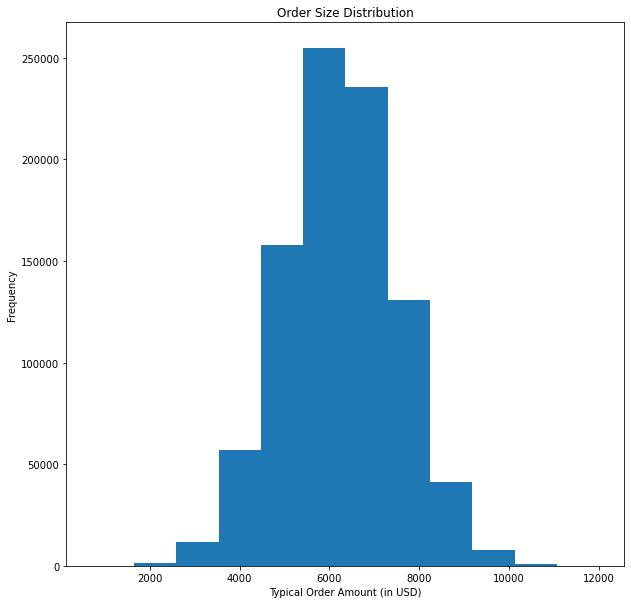

In [4]:
import matplotlib.pyplot as plt

hist=df['output.trade_volume'].plot.hist(bins=12,title="Order Size Distribution",figsize=(10,10));
hist=hist.set_xlabel("Typical Order Amount (in USD)")

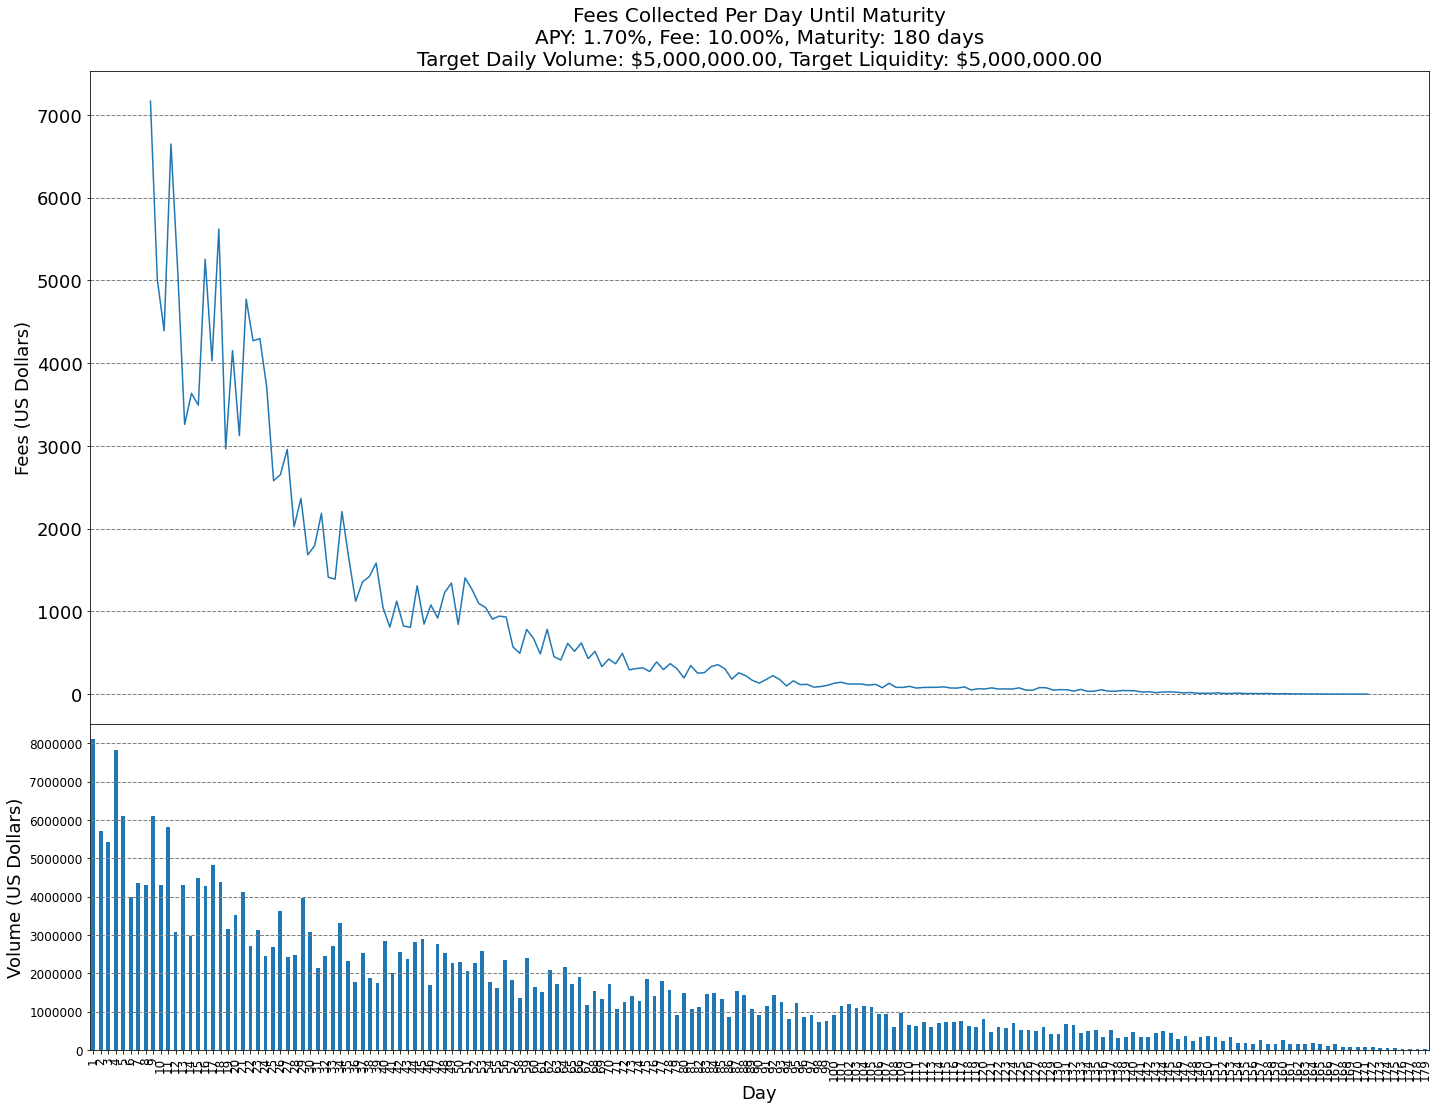

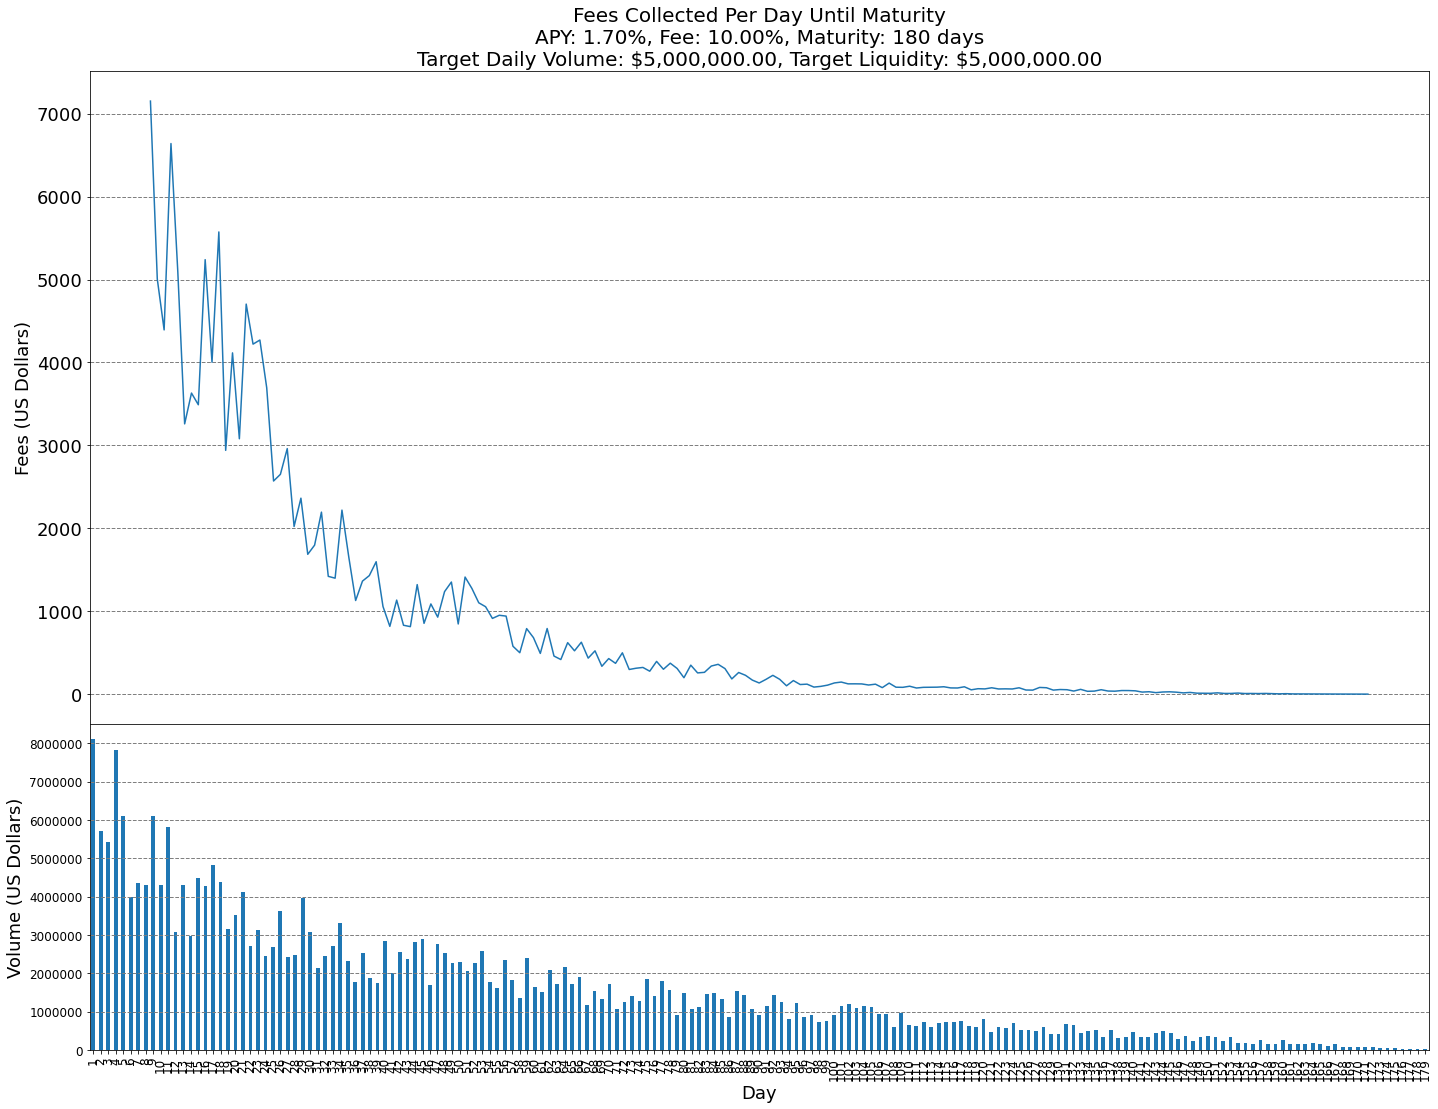

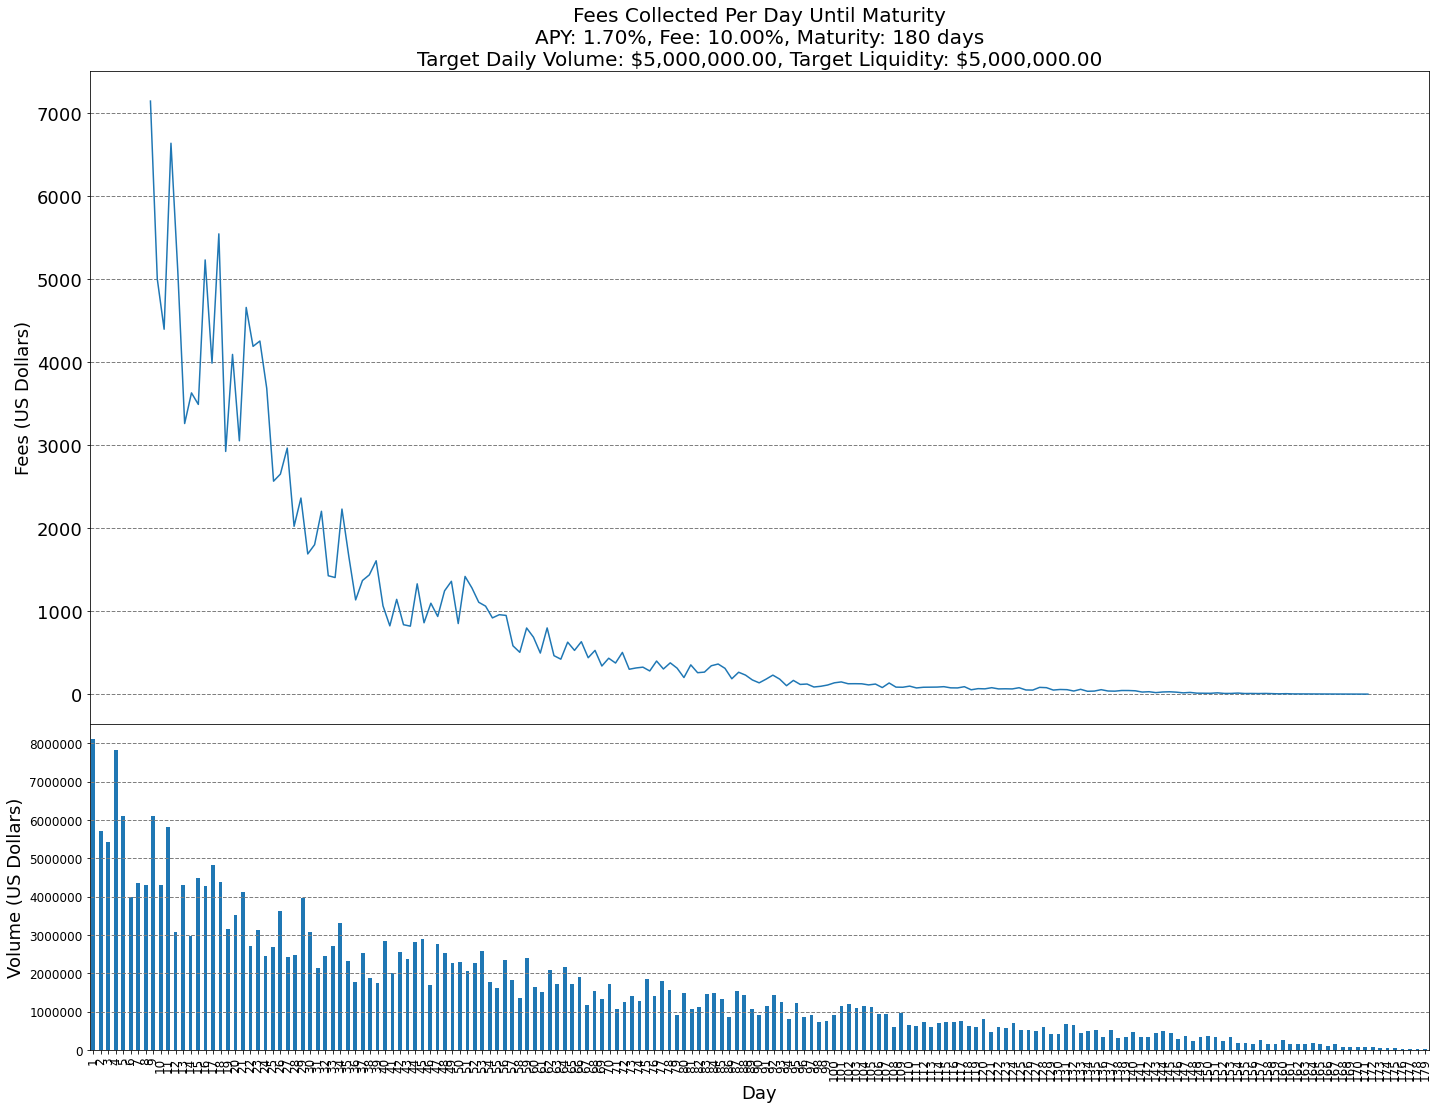

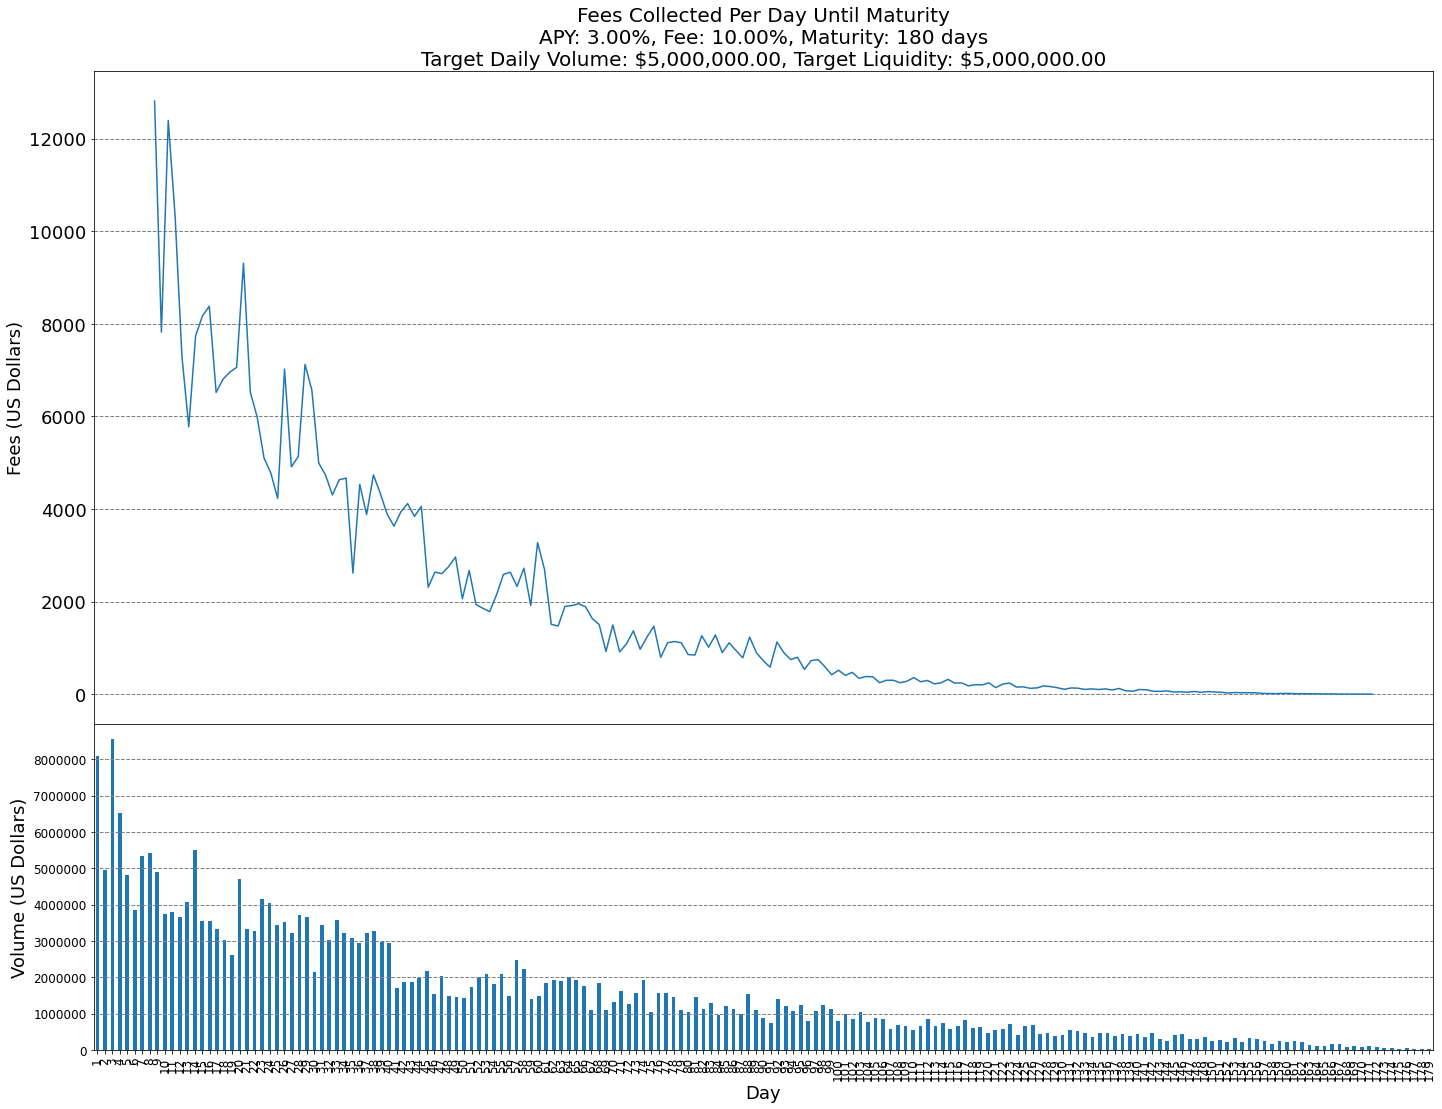

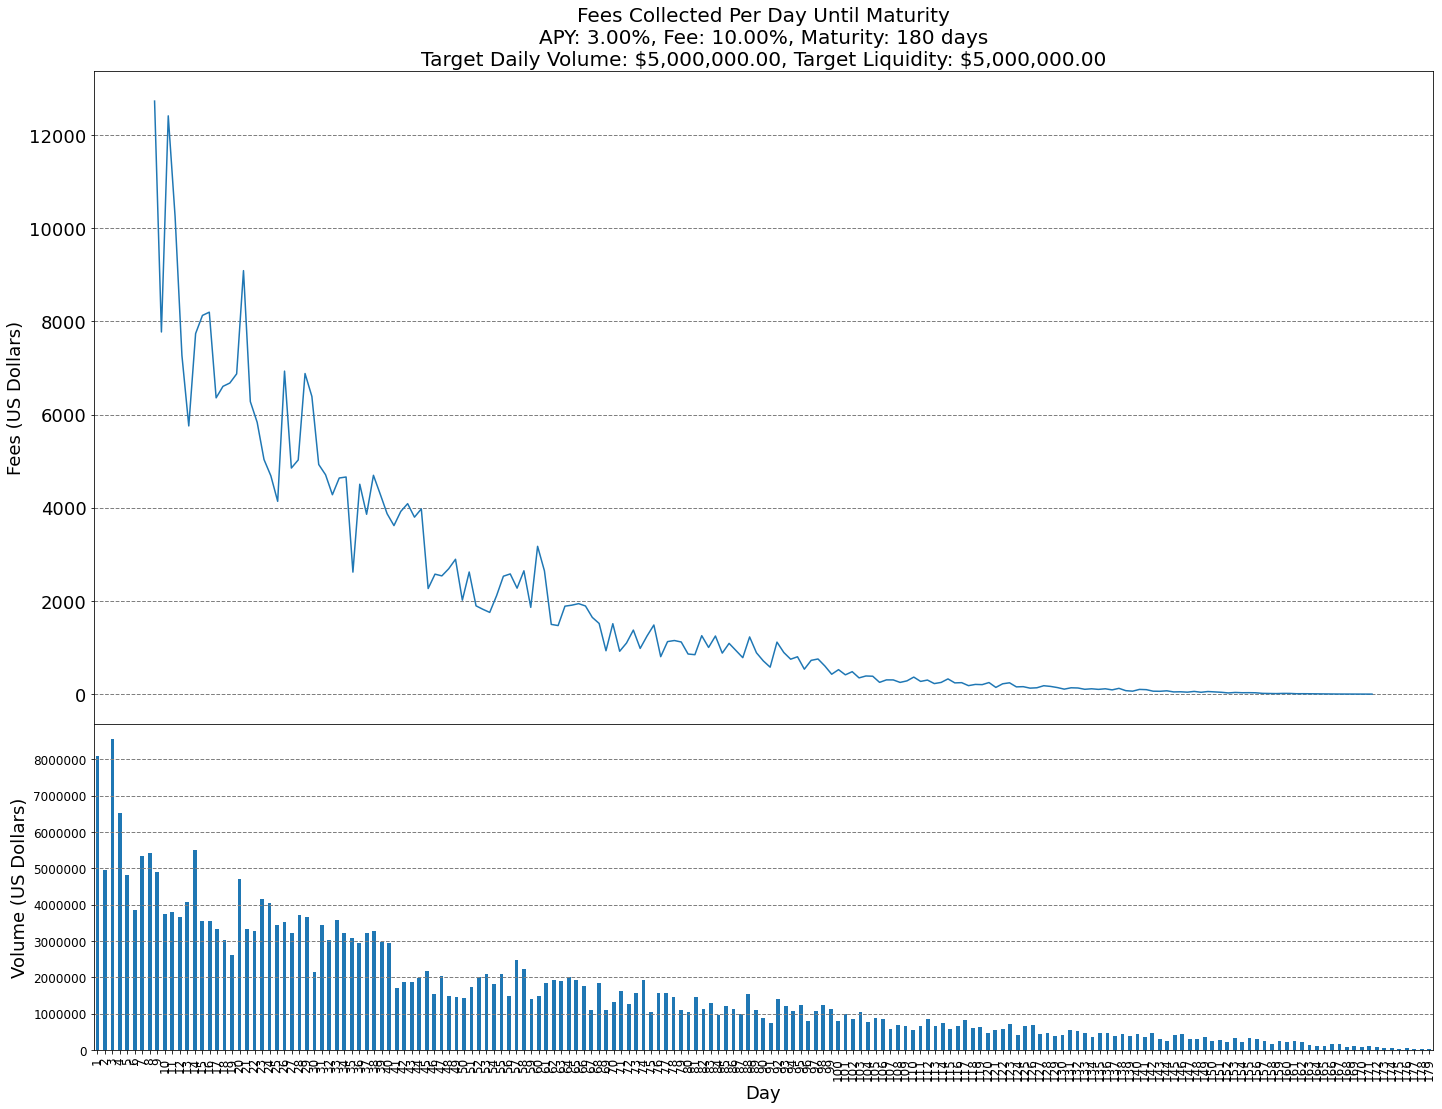

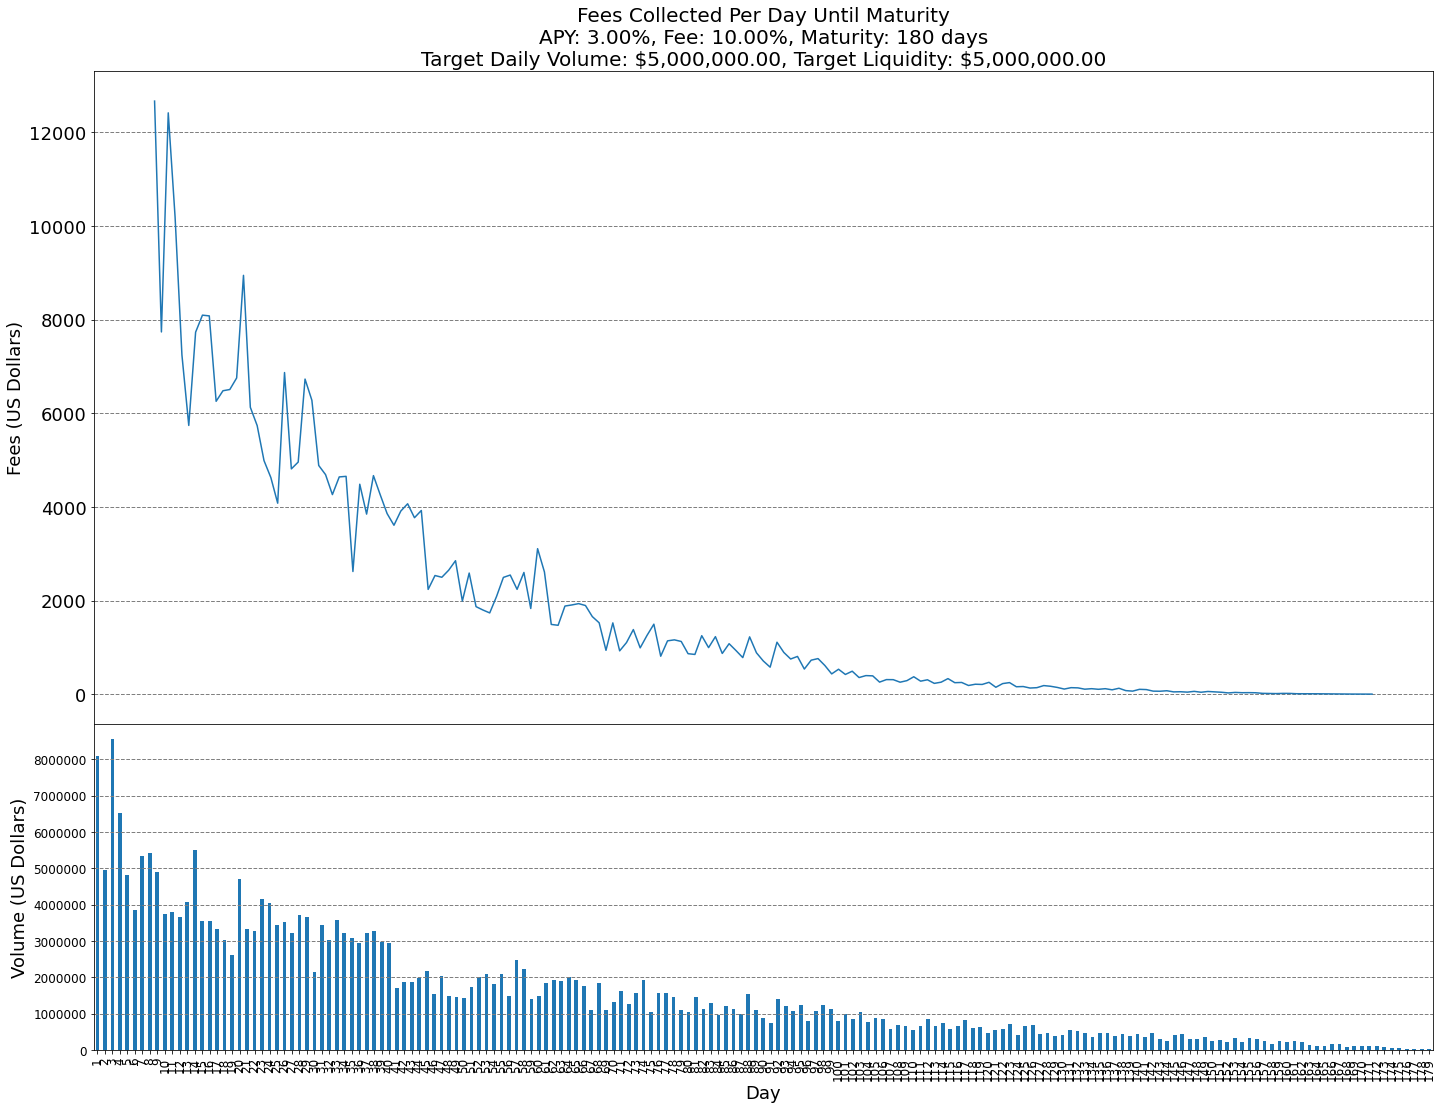

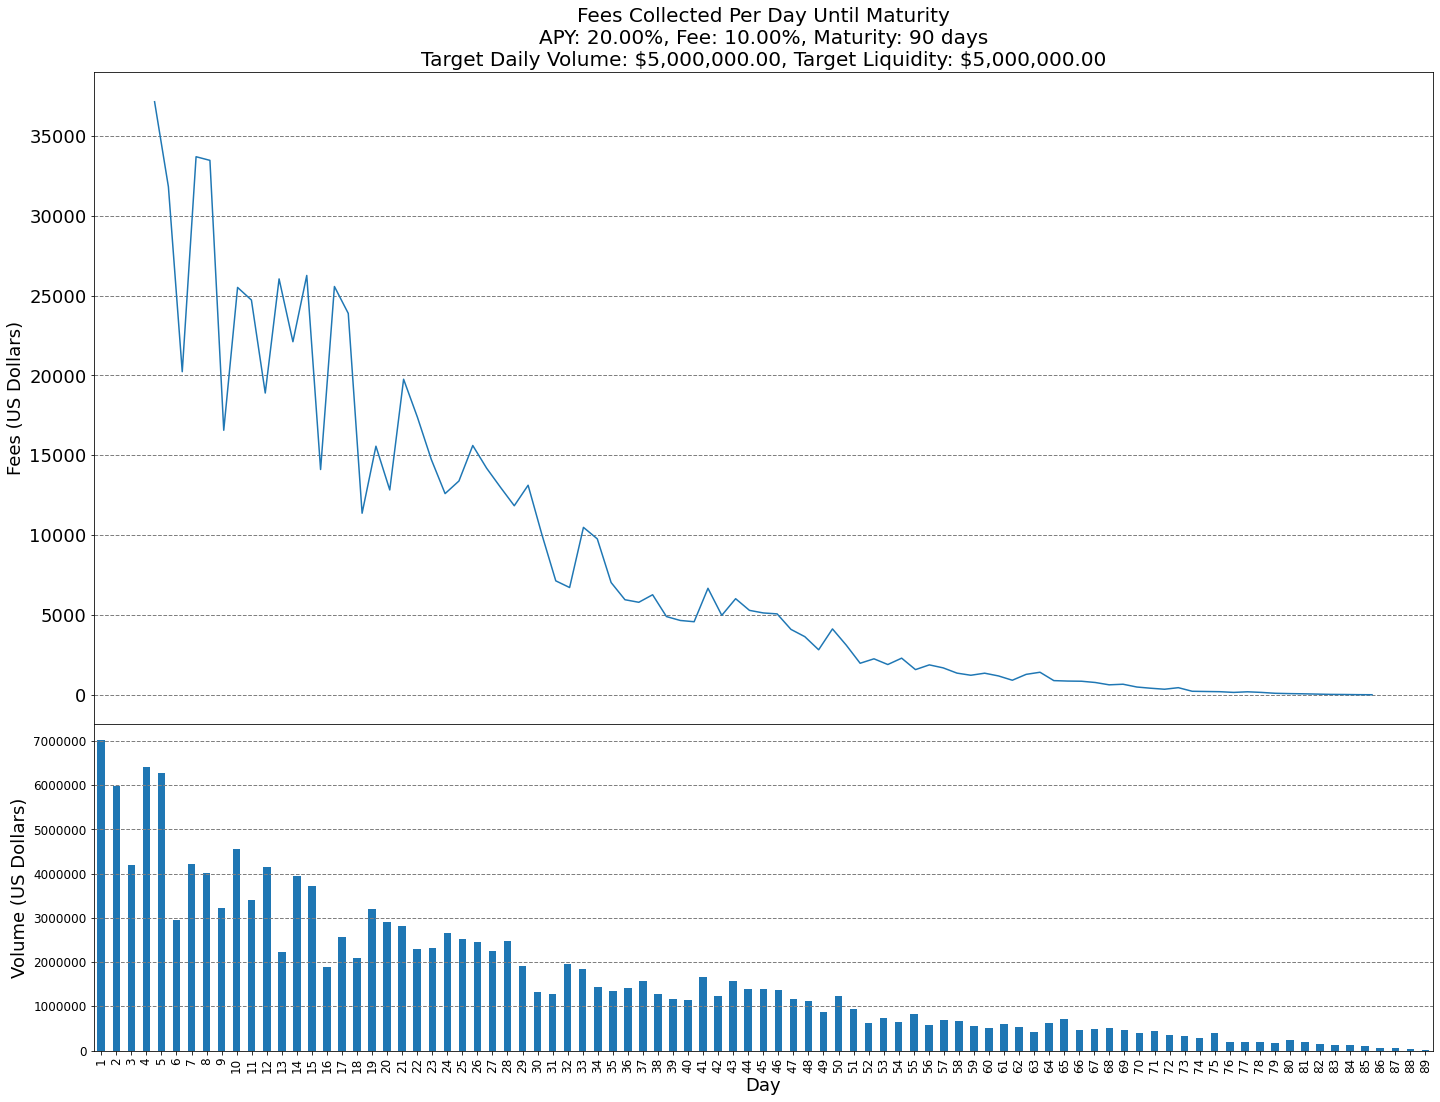

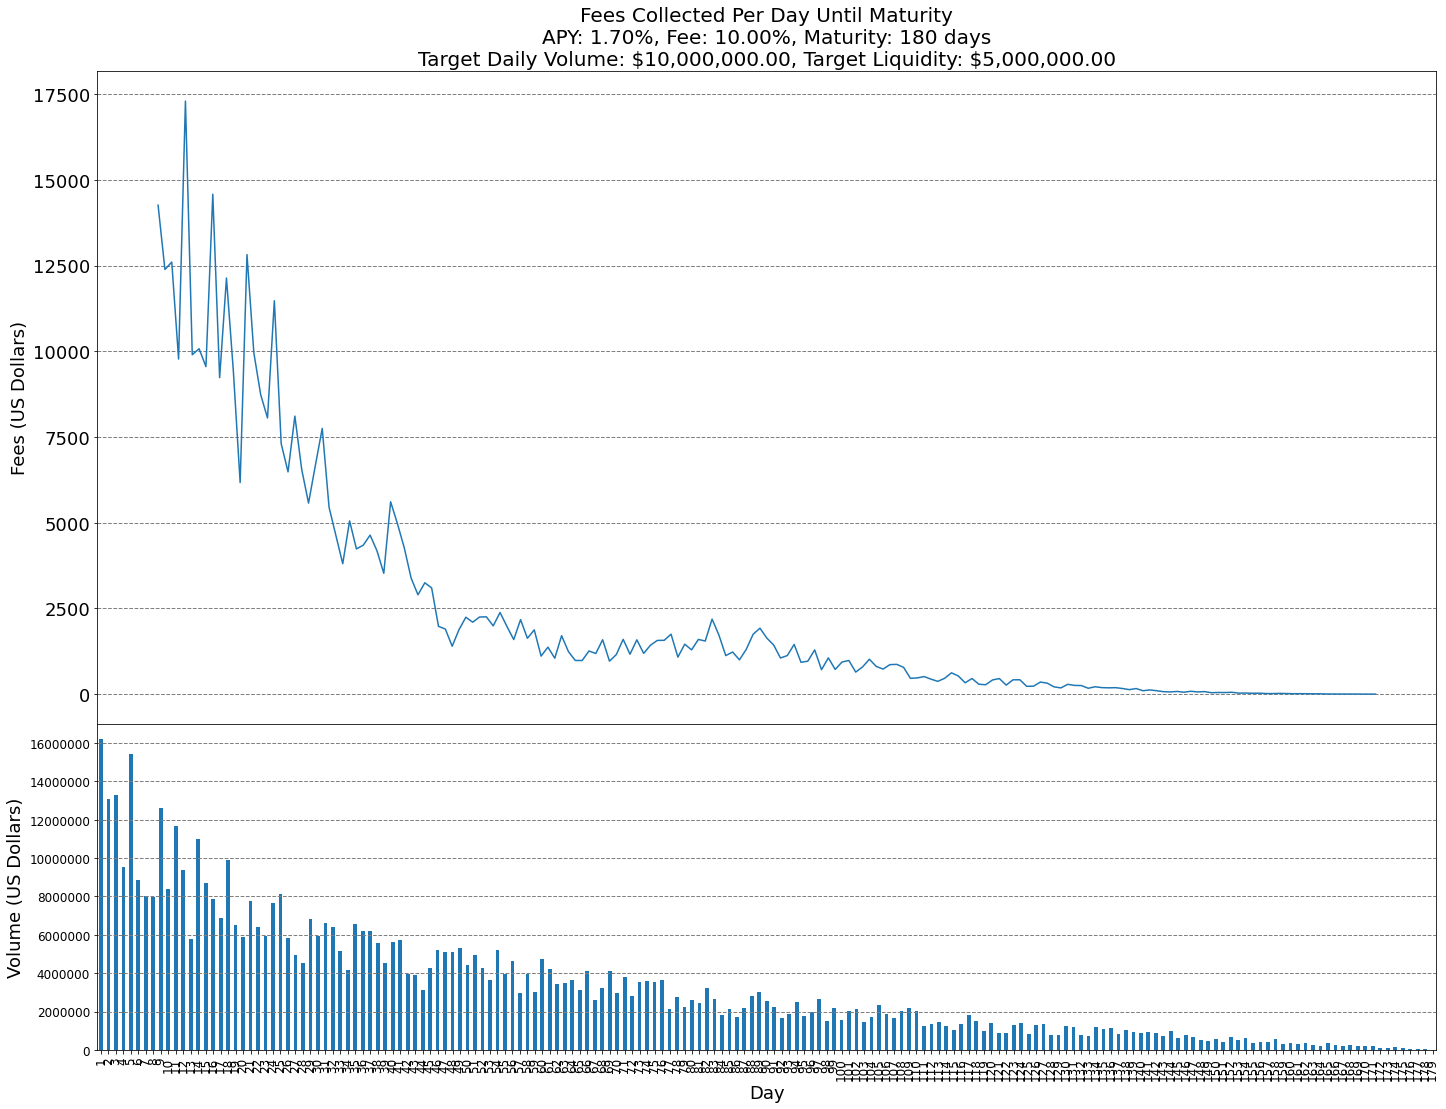

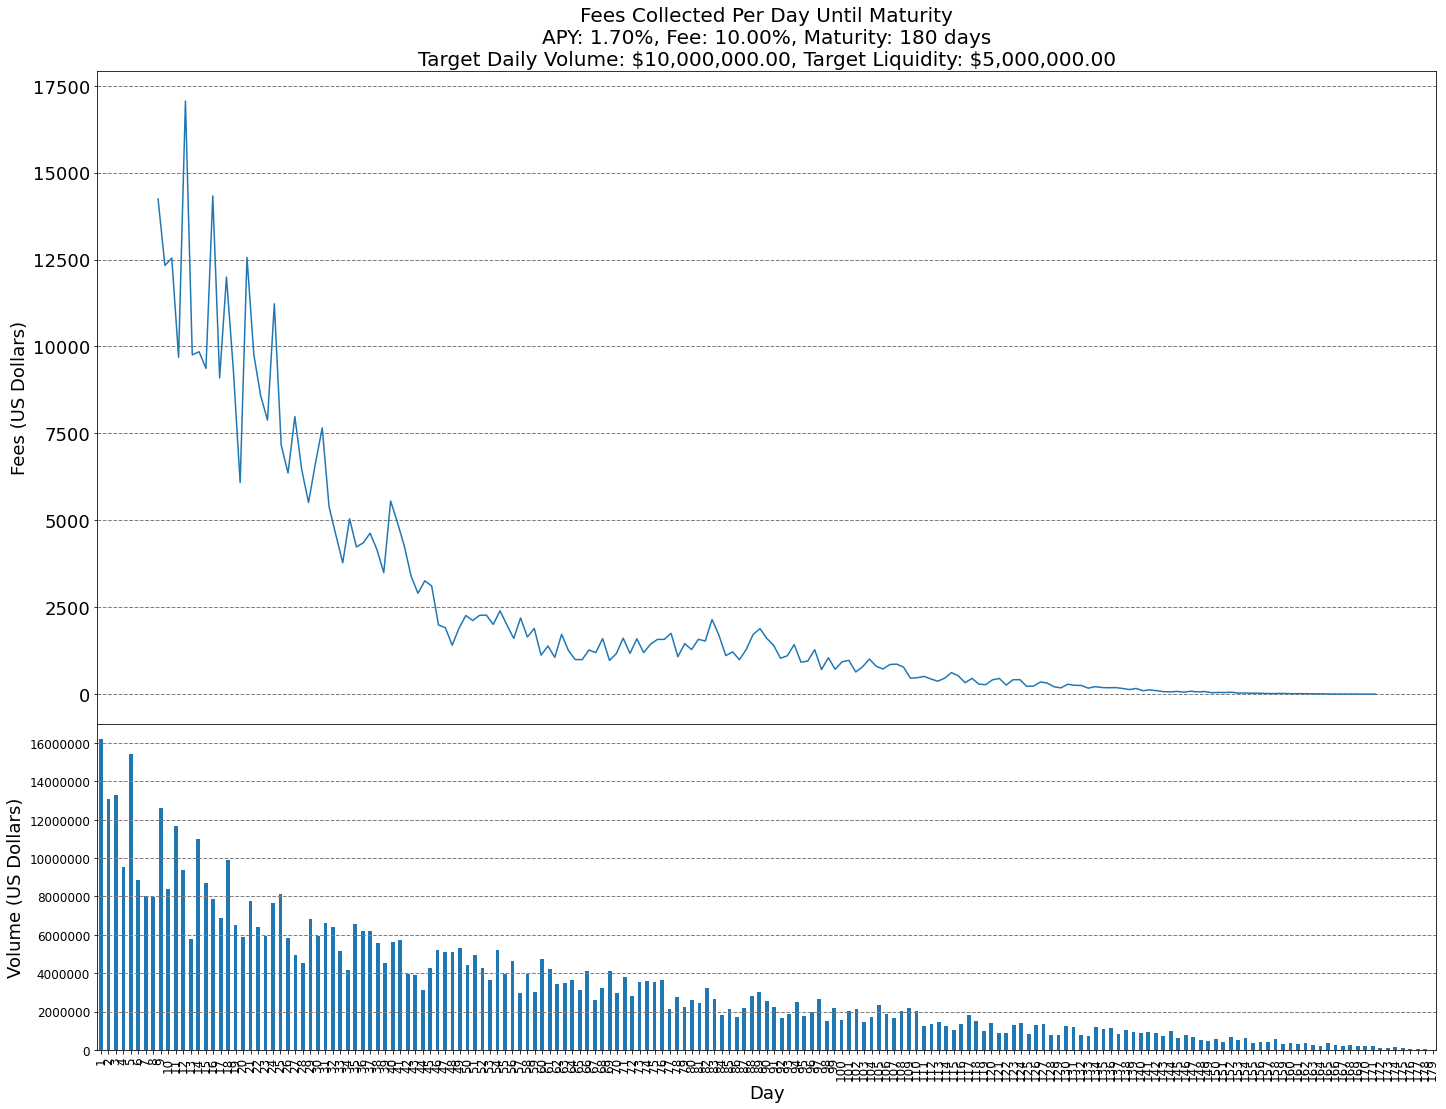

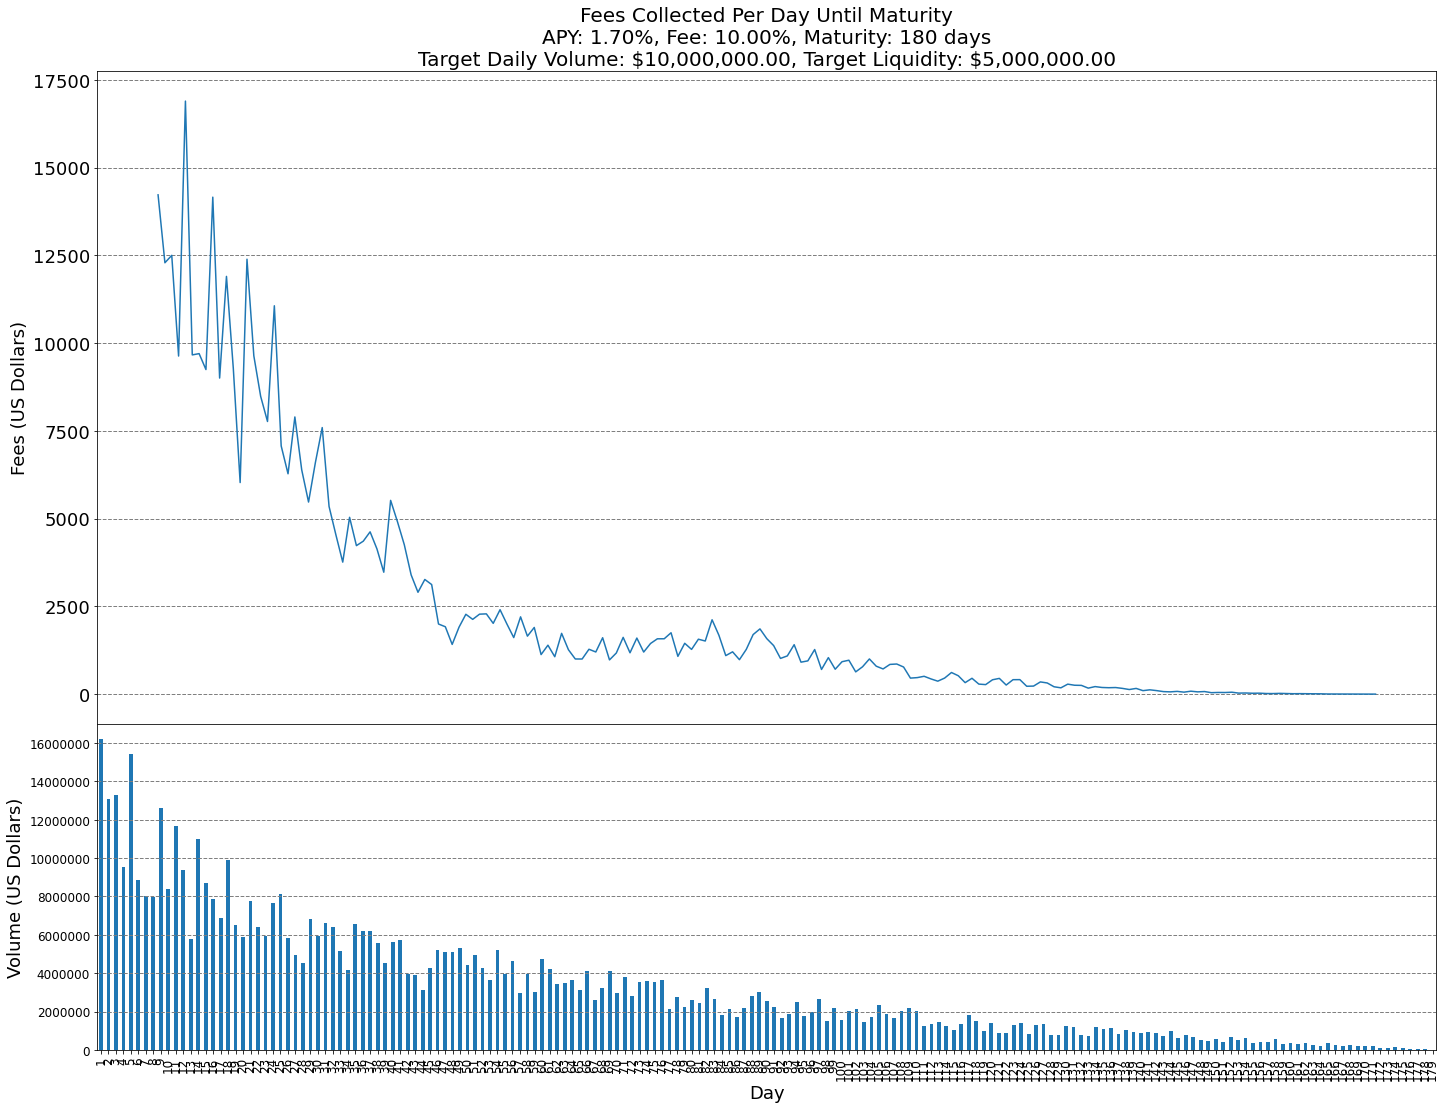

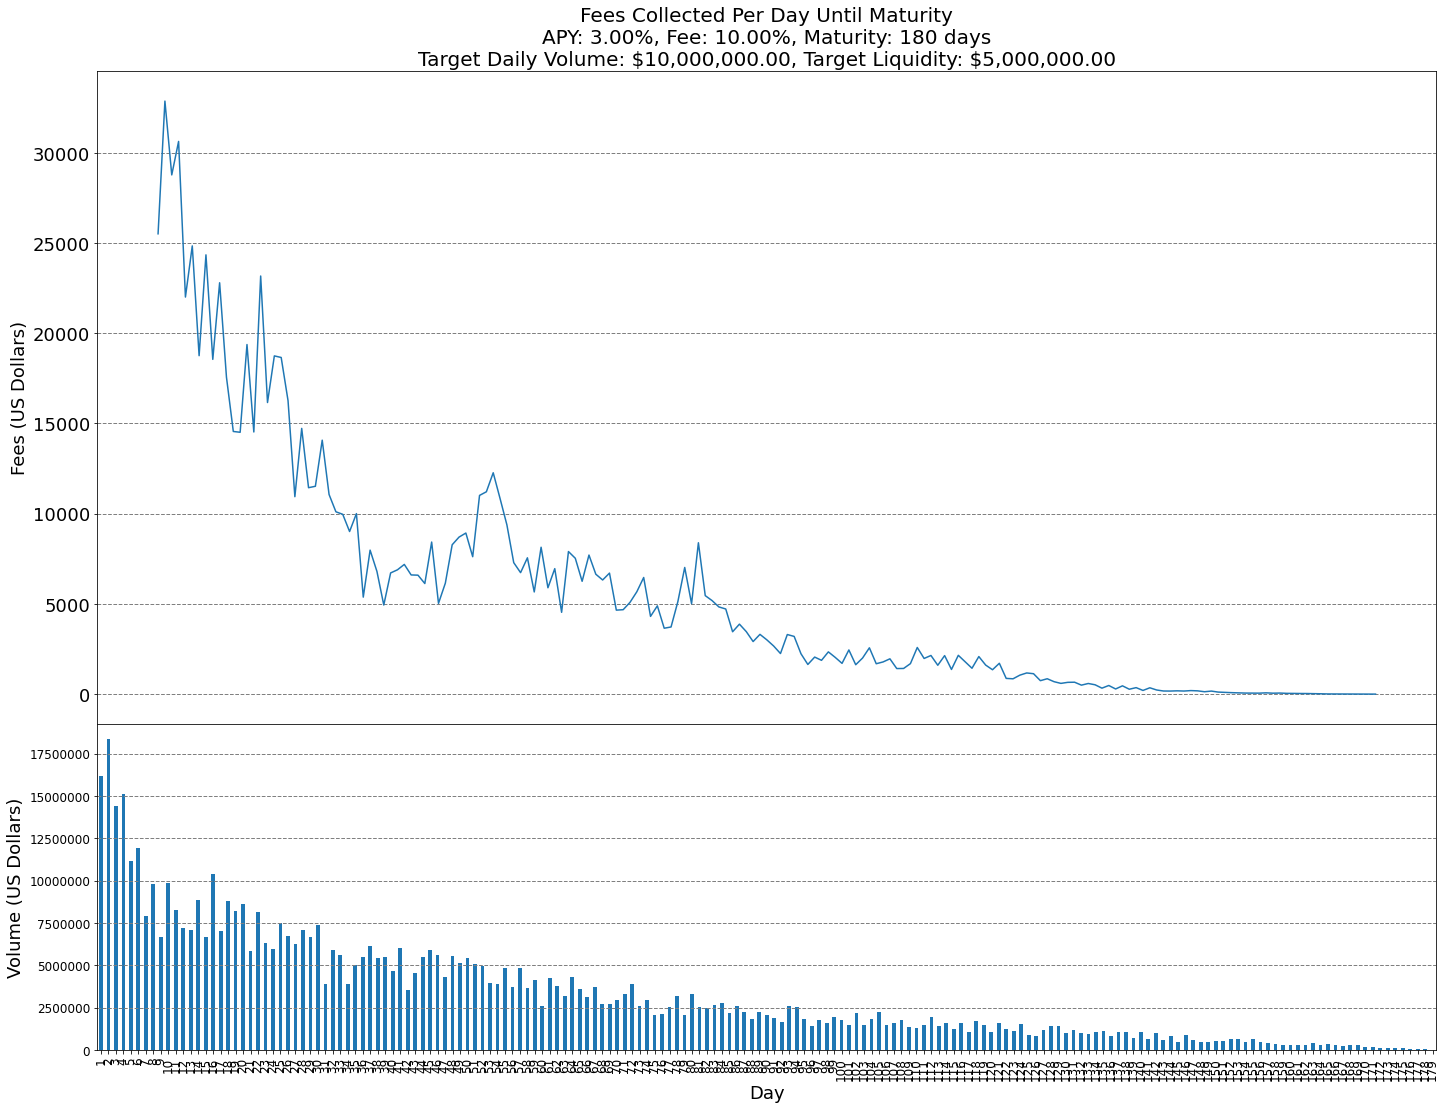

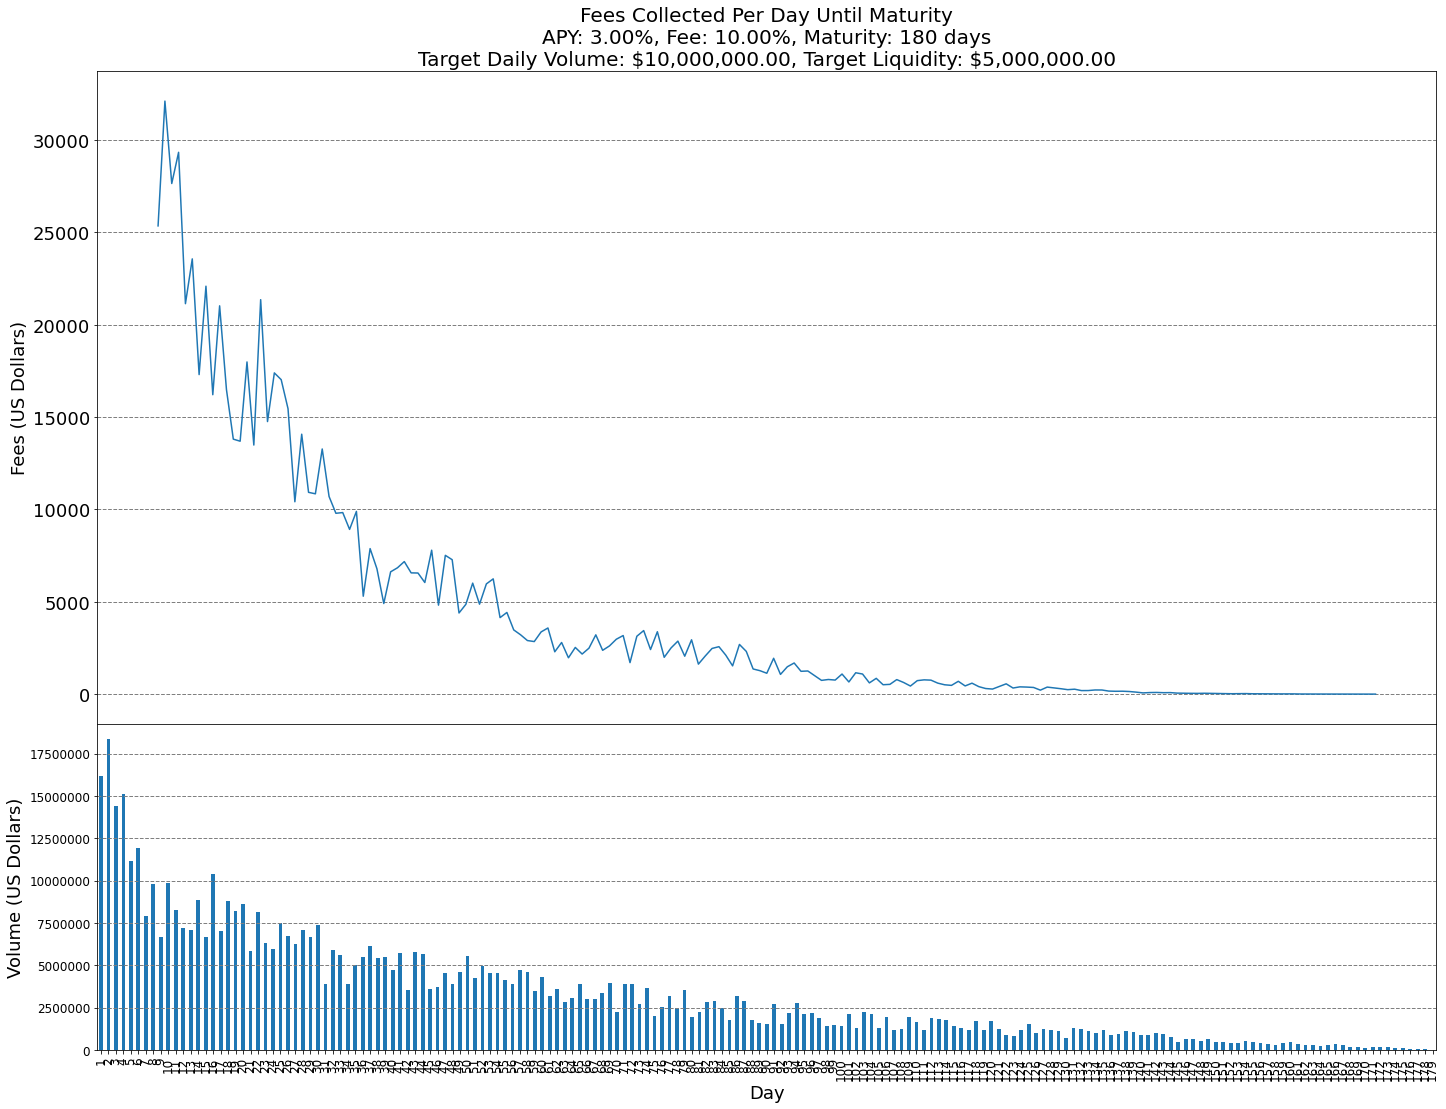

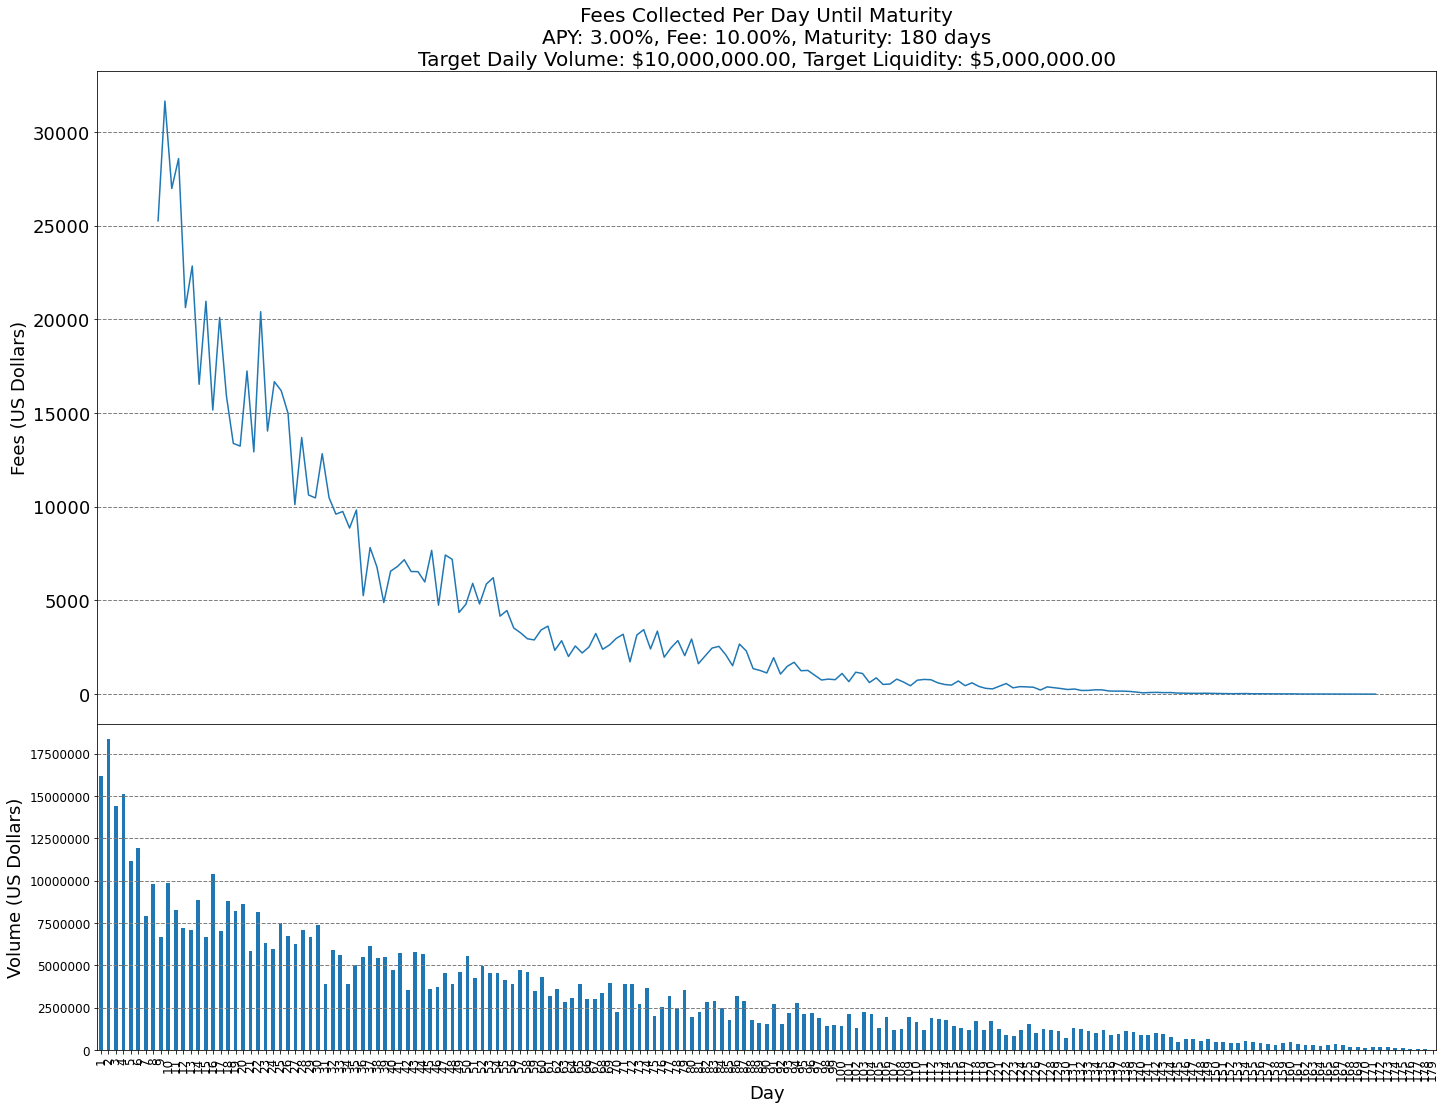

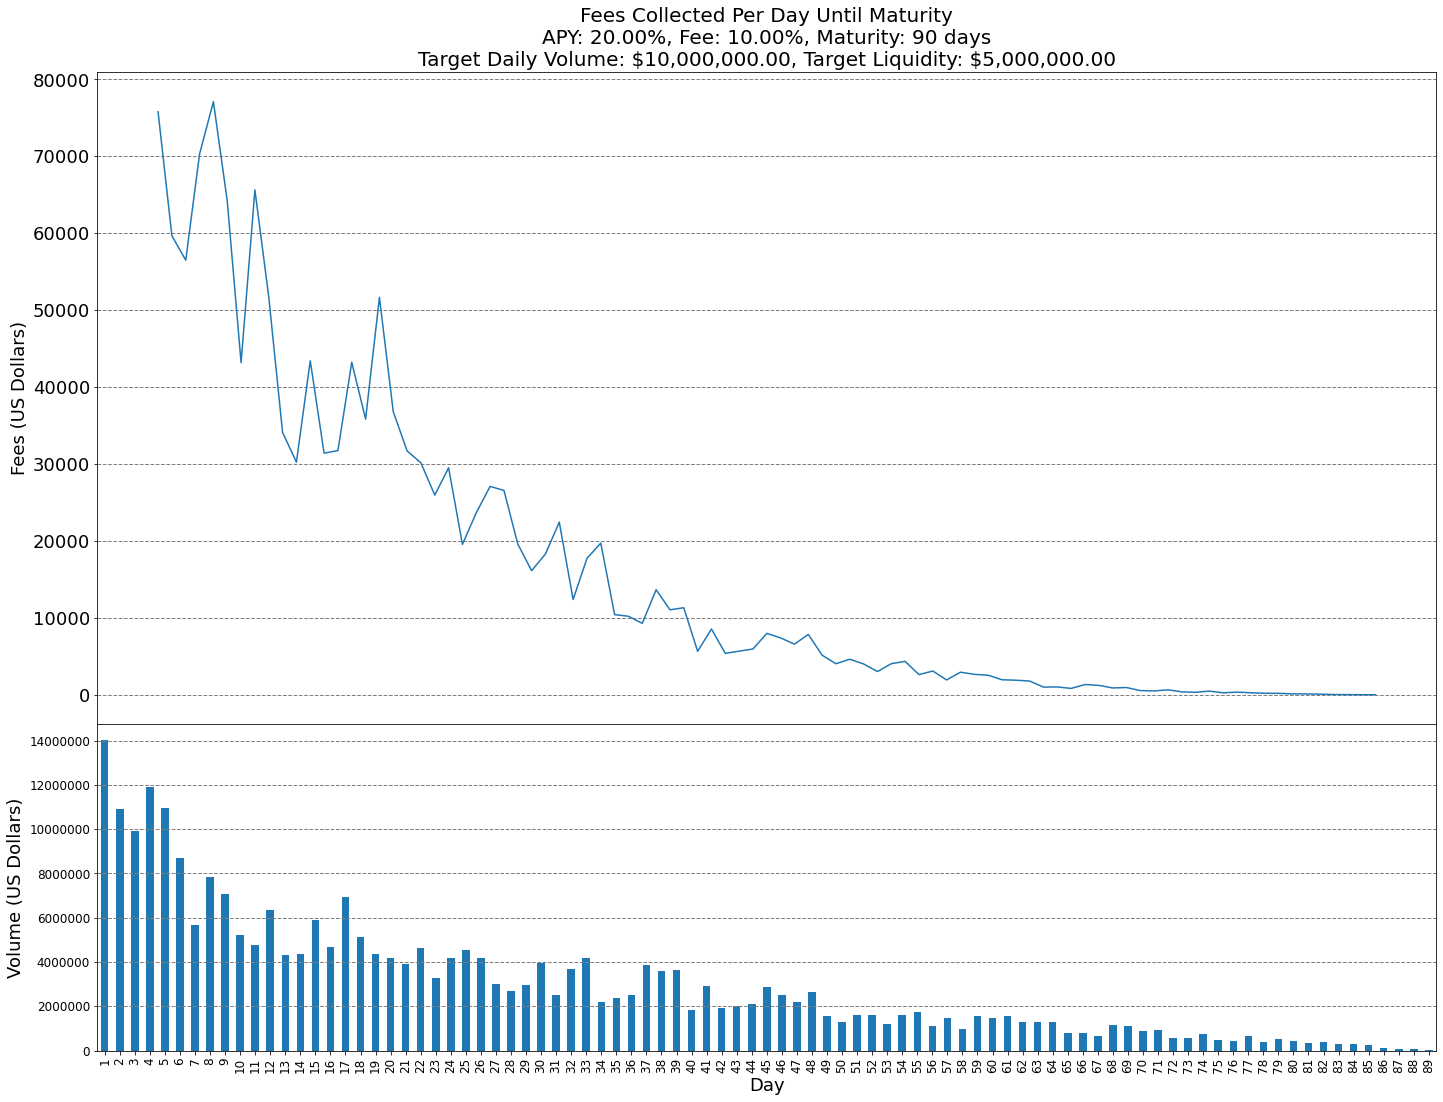

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec

dfs=[]
for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
  dfs.append(df[ (df['init.market_price']==yba["market_price"]) & (df['init.time_stretch']==yba["time_stretch"]) & (df['init.apy']==yba["apy"]) & (df['init.percent_fee']==g) & (df['init.days_until_maturity']==yba["days_until_maturity"]) & (df['init.target_liquidity']==target_liquidity) & (df['init.target_daily_volume']==target_daily_volume)].reset_index())

for _df in dfs:
    fig, ax = plt.subplots(ncols=1, nrows=2,gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[2,1]})
    df_fees_volume = _df.groupby(['input.day']).agg({'output.trade_volume':['sum']\
                                   ,'output.fee':['mean','std','min','max','sum']\
                                  })
    df_fees_volume.columns = ['_'.join(col).strip() for col in df_fees_volume.columns.values]
    df_fees_volume = df_fees_volume.reset_index()
    ax[0] = df_fees_volume.plot(x="input.day", y="output.fee_sum",figsize=(24,18),ax=ax[0]);
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Fees (US Dollars)",fontsize=18)
    ax[0].tick_params(axis = "both", labelsize=18)
    ax[0].grid(b=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
    ax[0].xaxis.set_ticklabels([])
    title = "Fees Collected Per Day Until Maturity\nAPY: {:.2f}%, Fee: {:.2f}%, Maturity: {:} days\nTarget Daily Volume: \${:,.2f}, Target Liquidity: \${:,.2f}".format(_df['init.apy'][0],_df['init.percent_fee'][0]*100,_df['init.days_until_maturity'][0],_df['init.target_daily_volume'][0],_df['init.target_liquidity'][0])
    ax[0].set_title(title,fontsize=20)
    ax[0].legend().set_visible(False)

    ax[1] = df_fees_volume.plot(kind='bar',x="input.day", y="output.trade_volume_sum",ax=ax[1]);
    ax[1].set_xlabel("Day",fontsize=18)
    ax[1].set_ylabel("Volume (US Dollars)",fontsize=18)
    ax[1].tick_params(axis = "both", labelsize=12)
    ax[1].grid(b=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
    ax[1].legend().set_visible(False)
    ax[1].ticklabel_format(style='plain',axis='y')
    fig.subplots_adjust(wspace=None, hspace=None)

In [6]:
pd.options.display.float_format = '{:,.8f}'.format
df_fees_agg = df.groupby(['init.apy','init.percent_fee','init.time_stretch','init.market_price','init.target_liquidity','init.days_until_maturity','init.target_daily_volume']).agg({'output.fee':['count','sum'],'output.trade_volume':['mean','sum'],'output.slippage':['mean'],'input.amount_specified':['mean']})
df_fees_agg.columns = ['_'.join(col).strip() for col in df_fees_agg.columns.values]
df_fees_agg = df_fees_agg.reset_index()
df_fees_agg['init.percent_fee'] = df_fees_agg['init.percent_fee'].round(2)
df_fees_agg['output.mean_daily_volume'] = df_fees_agg['output.trade_volume_sum']/df_fees_agg['init.days_until_maturity']
df_fees_agg['output.apr'] = (df_fees_agg['output.fee_sum']/df_fees_agg['init.target_liquidity']) * (365/df_fees_agg['init.days_until_maturity'])*100
df_fees_agg = df_fees_agg.drop(columns=['input.amount_specified_mean','init.percent_fee']).reset_index()
df_fees_agg

,index,init.apy,init.time_stretch,init.market_price,init.target_liquidity,init.days_until_maturity,init.target_daily_volume,output.fee_count,output.fee_sum,output.trade_volume_mean,output.trade_volume_sum,output.slippage_mean,output.mean_daily_volume,output.apr
0,0,1.70000000,20,50000,5000000,180,5000000,45324,"150,719.09217444","6,242.76205624","282,946,947.43720996",-0.22474255,"1,571,927.48576228",6.11249652
1,1,1.70000000,20,50000,5000000,180,10000000,93533,"415,970.40082676","6,249.45440821","584,530,219.16281021",-0.01035493,"3,247,390.10646006",16.86991070
2,2,1.70000000,30,50000,5000000,180,5000000,45324,"150,622.23703773","6,242.76354463","282,947,014.89677542",-0.22631828,"1,571,927.86053764",6.10856850
3,3,1.70000000,30,50000,5000000,180,10000000,93533,"418,589.87638292","6,249.45905387","584,530,653.68603945",-0.01375230,"3,247,392.52047800",16.97614499
4,4,1.70000000,40,50000,5000000,180,5000000,45324,"150,504.57795092","6,242.76569394","282,947,112.31216758",-0.22859108,"1,571,928.40173426",6.10379677
5,5,1.70000000,40,50000,5000000,180,10000000,93533,"422,504.61843179","6,249.46607258","584,531,310.16636741",-0.01890321,"3,247,396.16759093",17.13490953
6,6,3.00000000,20,50000,5000000,180,5000000,45157,"335,942.20894294","6,244.35877351","281,976,509.13537735",-0.47337700,"1,566,536.16186321",13.62432292
7,7,3.00000000,20,50000,5000000,180,10000000,93687,"751,671.37249359","6,247.07380438","585,269,603.51074326",0.19788884,"3,251,497.79728191",30.48445011
8,8,3.00000000,30,50000,5000000,180,5000000,45140,"338,508.59401832","6,244.80558557","281,890,524.13272768",-0.48755846,"1,566,058.46740404",13.72840409
9,9,3.00000000,30,50000,5000000,180,10000000,93687,"767,921.81767404","6,247.10780103","585,272,788.55501902",0.18712868,"3,251,515.49197233",31.14349594


In [5]:
#df_fees_agg.to_csv("fees.csv")

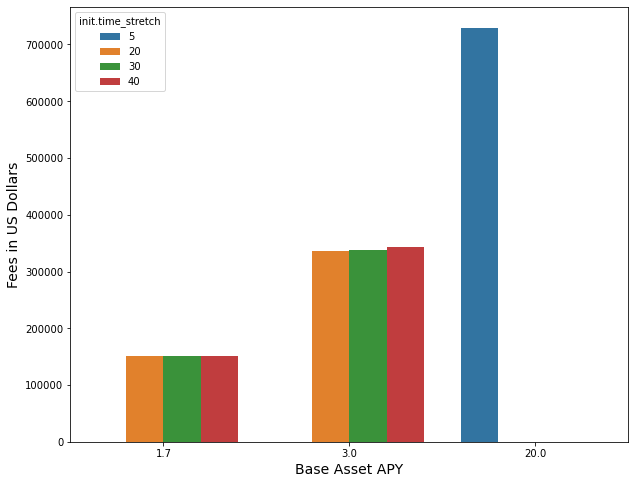

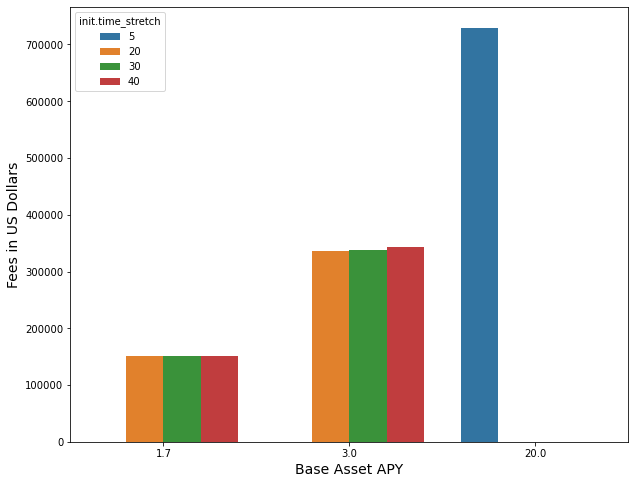

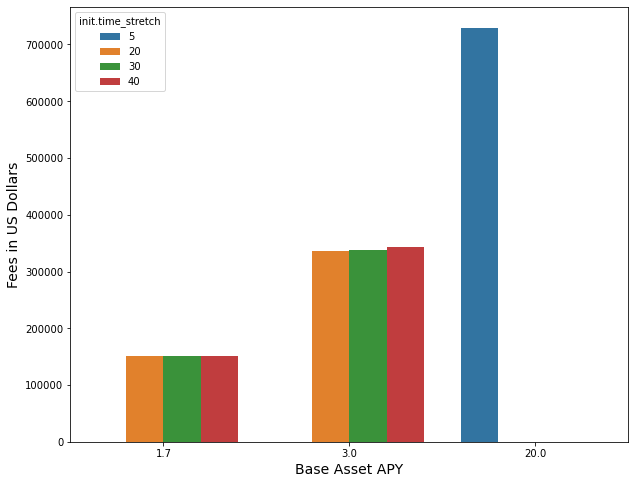

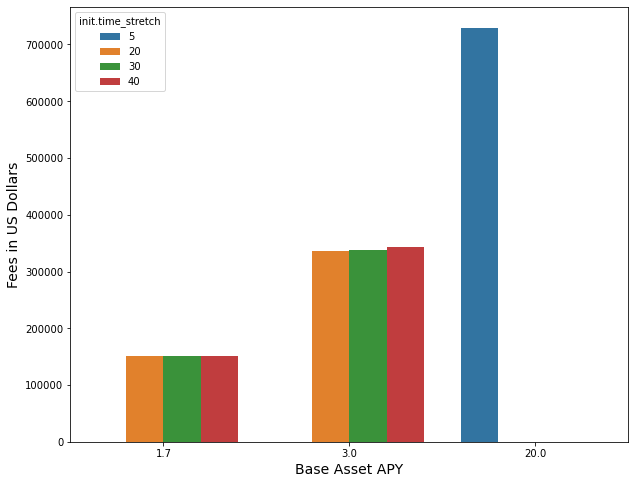

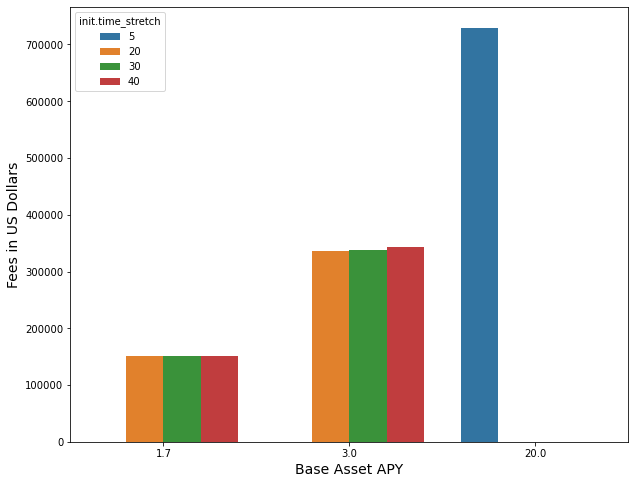

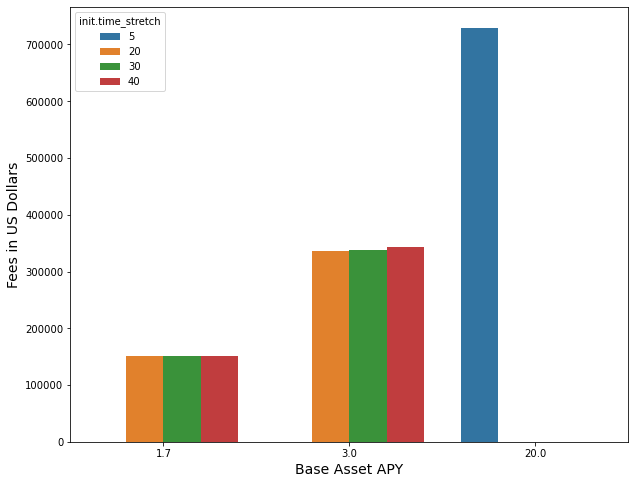

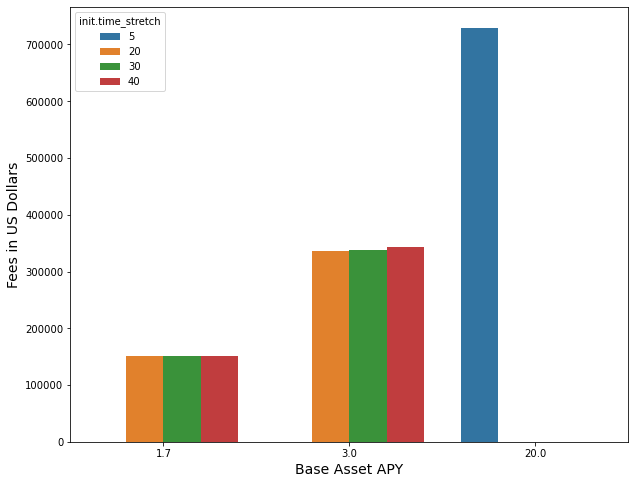

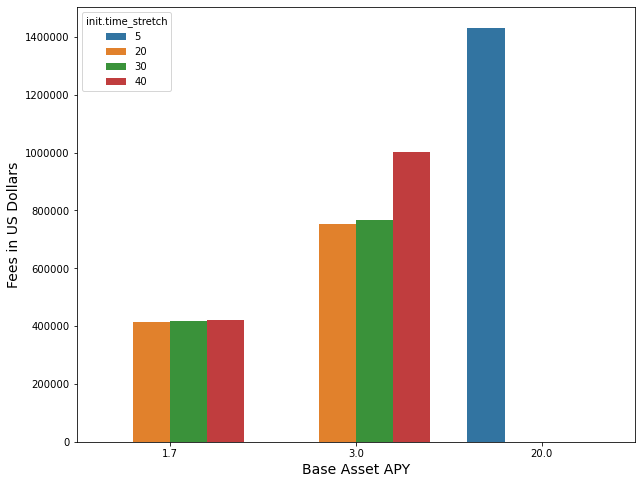

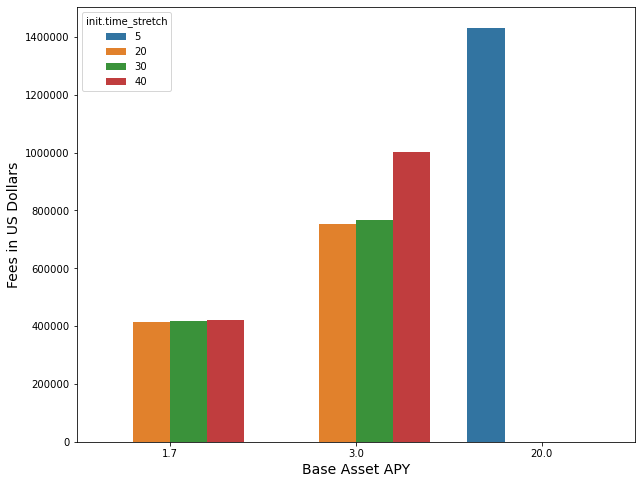

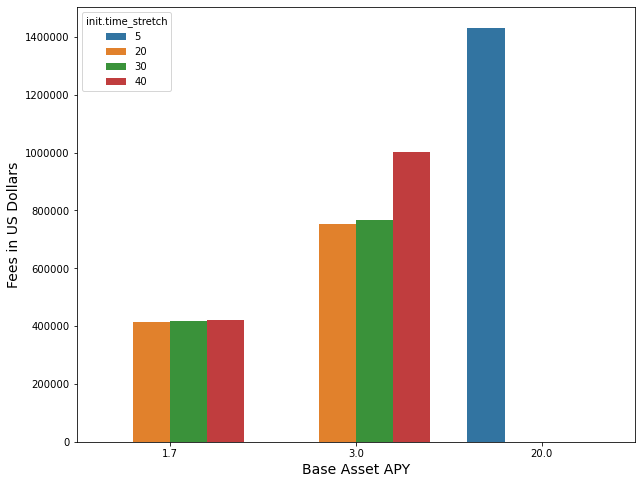

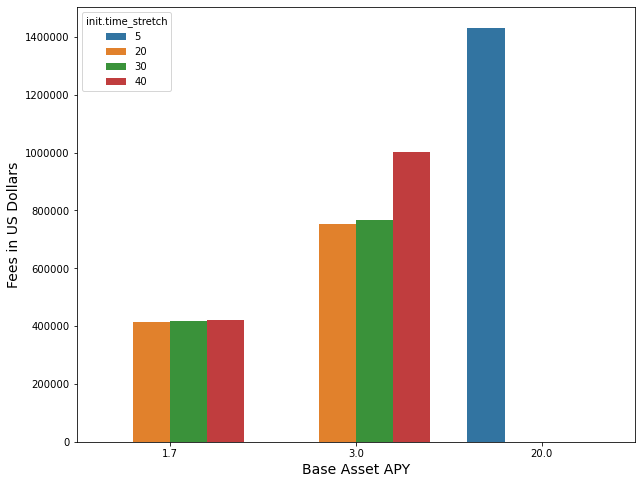

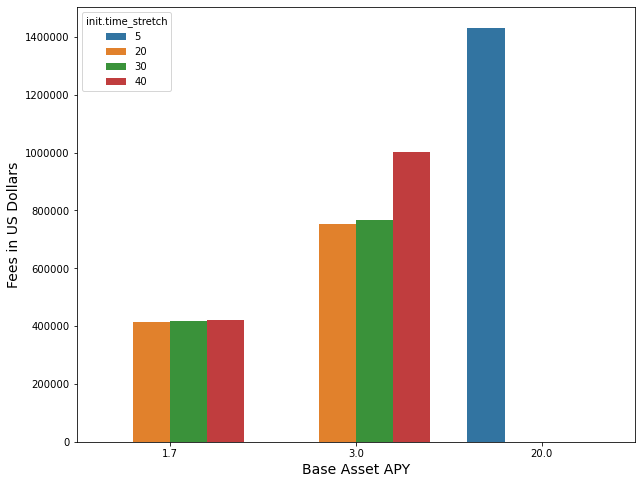

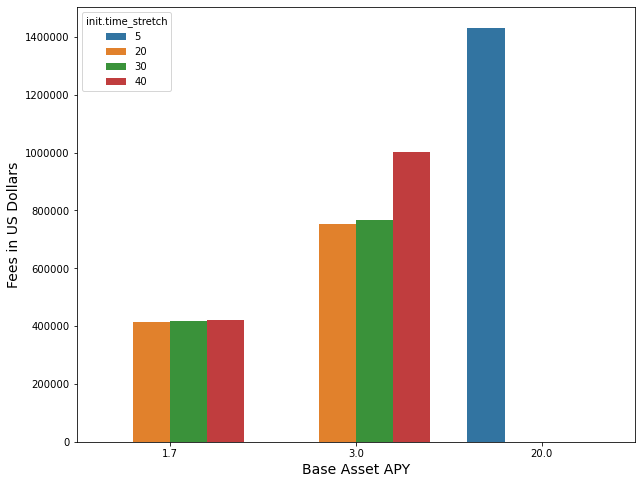

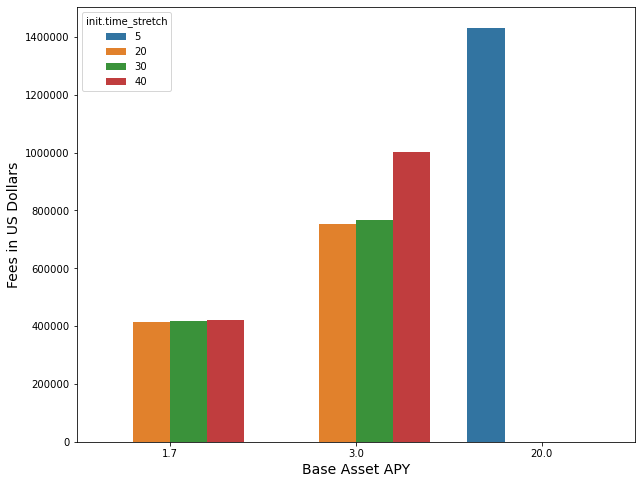

In [7]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

#plt.figure(figsize=(20, 20))
#for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
#condition = (df_fees_agg['init.market_price']==yba["market_price"]) & (df_fees_agg['init.days_until_maturity']==yba["days_until_maturity"]) & (df_fees_agg['init.target_liquidity']==target_liquidity) & (df_fees_agg['init.target_daily_volume']==target_daily_volume)
for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
  plt.figure(figsize=(10, 8))
  condition =   (df_fees_agg['init.target_liquidity']==target_liquidity) & (df_fees_agg['init.target_daily_volume']==target_daily_volume)
  sns.barplot(x="init.apy", 
              y="output.fee_sum", 
              hue="init.time_stretch", 
              data=df_fees_agg[condition],
              ci=None)
  plt.ticklabel_format(style='plain',axis='y')
  plt.ylabel("Fees in US Dollars", size=14)
  plt.xlabel("Base Asset APY", size=14)
  #title = "Fees Collected Per Day Until Maturity\nAPY: {:.2f}%, Fee: {:.2f}%, Maturity: {:} days\nTarget Daily Volume: \${:,.2f}, Target Liquidity: \${:,.2f}".format(_df['init.apy'][0],_df['init.percent_fee'][0]*100,_df['init.days_until_maturity'][0],_df['init.target_daily_volume'][0],_df['init.target_liquidity'][0])
  #plt.title("Cumulative Fees for 30 day FYT\n"+"Target Volume = " + str(df_fees_agg[condition]['init.target_daily_volume'].iloc[0]) + "\nTarget Liquidity = " + str(df_fees_agg[condition]['init.target_liquidity'].iloc[0]), size=14)
